# Pover-T Tests: Predicting Poverty
[Hosted by DrivenData](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/leaderboard/)

## Libraries and and helper functions

In [1]:
# For data manipulation and feature engineering
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

# For calculating feature importances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

# For building the actual models (each one will be a pipeline consisting 
# of a custom feature selector and a gradient boosted classifier)
from sklearn.pipeline import Pipeline
from tools import scores # helper function for feature selector
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingClassifier

# For exporting the predictions
from os import listdir

# Hide some warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load and process the data for country with the given letter
def load_data(letter):
    prefix = 'Pover-T_Tests_Predicting_Poverty_-_Country_'
    
    # Household-level data
    dfh = pd.read_csv(
        prefix + letter + '_Household_Train.csv'
    ).set_index(['id','country'])
    
    # Individual-level data
    dfi = pd.read_csv(
        prefix + letter + '_Individual_Train.csv'
    ).drop('poor', 1)

    # For simplicity, the testing/unlabeled data is appended with label -1
    # (I would not typically do this in a real-life situation...)
    dfh = dfh.append(
        pd.read_csv(
            prefix + letter + '_Household_Test.csv' 
        ).set_index(['id','country']).assign(poor = -1)
    )
    dfi = dfi.append(
        pd.read_csv(
            prefix + letter + '_Individual_Test.csv'
        ).assign(poor = -1)
    )

    # Get the non-numerical column names from the household-level data
    cols = [c for c in dfh.columns if dfh[c].dtype == object]
    
    # The rest are numerical (except the label column)
    ncols = [c for c in dfh.columns if c not in cols and c != 'poor']

    # Make dummy variables from the non-numerical individual-level data
    # (except for country, which isn't really a feature)
    dfi = pd.get_dummies(
        dfi, 
        dummy_na = True, 
        columns = [
            c for c in dfi.columns 
            if dfi[c].dtype == object 
            and c != 'country'
        ]
    )

    # Create rules for aggregating the individual-level data by household
    groupdict = {}
    for c in dfi.columns:
        # Do nothing with country, household id, or "poor" flag
        if c in ['country', 'id', 'poor']: continue
        # Count the individuals in each household
        if c == 'iid': groupdict[c] = 'count'
        # Sum any discrete numerical features by household
        elif dfi[c].dtype in ['uint8', 'int64']: groupdict[c] = 'sum'
        # Take the household mean for each of the rest
        else: groupdict[c] = 'mean'

    # Attach the aggregated individual-level features to each household
    dfh = dfh.join(
        dfi.groupby(['id','country']).agg(groupdict),
        rsuffix = '_i'
    )

    # Calculate some new features by taking the product, difference, 
    # and sum of each pair of household-level numerical features
    for c1, c2 in combinations(ncols, 2):
        dfh['%s__times__%s' % (c1, c2)] = dfh[c1] * dfh[c2]    
        dfh['%s__minus__%s' % (c1, c2)] = dfh[c1] - dfh[c2]
        dfh['%s__plus__%s' % (c1, c2)]  = dfh[c1] + dfh[c2]

    # Drop any feature that takes on only one value
    to_drop = []
    for c in dfh.columns: 
        if len(dfh[c].unique()) <= 1: to_drop.append(c)
    dfh = dfh.drop(to_drop, 1)

    # Get the targets
    y = dfh.poor.astype(int)

    # Encode the non-numerical features according to 
    # their corresponding poverty rate
    for c in [col for col in dfh.columns if dfh[col].dtype == object]:
        temp = dfh[y >= 0][[c, 'poor']].groupby(c).mean()
        dfh[c] = dfh.join(temp, on = c, rsuffix = '_avg').poor_avg

    # Return the features and targets
    X = dfh.fillna(-999999).drop('poor', 1)
    return X, y


In [3]:
# Cross-validated permutation importances, based on log loss
def permutation_importances(X, y, cv = 5, progress = True):
    p_imp = [0] * X.shape[1]
    sk = StratifiedKFold(n_splits = cv, shuffle = True)
    for itrain, itest in sk.split(X, y):
        clf = RandomForestClassifier(
            n_jobs = -1, n_estimators = X.shape[1] * 3
        ).fit(X.iloc[itrain], y.iloc[itrain])
        ll = log_loss(y.iloc[itest], clf.predict_proba(X.iloc[itest]))
        for i, column in tqdm(
            enumerate(X.columns), 
            desc = 'Get importances (in %d folds)' % cv,
            total = X.shape[1]
        ) if progress else enumerate(X.columns):
            Xtemp = X.iloc[itest].copy()
            Xtemp[column] = Xtemp[column].sample(frac = 1.0).values
            p_imp[i] += log_loss(y.iloc[itest], clf.predict_proba(Xtemp)) - ll
    return [i/cv for i in p_imp]

# Calculate permutation importances in batches (for large number of features)
def batch_importances(X, y, chunk = 50):
    p_imp = []
    for i in tqdm(
        range(0, len(X.columns), chunk), 
        desc = 'Calculating importances in batches'
    ):
        p_imp += permutation_importances(
            X.iloc[:,i:i+chunk], y,
            progress = False
        )
    return p_imp

# Calculate and visualize permutation importances 
def show_importances(X, y):
    imp = batch_importances(X[y >= 0], y[y >= 0], 100)
    posimp = sum(i > 1e-10 for i in imp)
    plt.rcParams['figure.figsize'] = 20,4
    plt.rcParams['font.size'] = 10
    plt.bar(
        x = range(len(imp)),
        height = sorted(imp, reverse = True),
        log = True
    )
    plt.xlim([-1, len(imp)])
    plt.title('Feature importances (%d of %d positive)' % (posimp, len(imp)))
    plt.grid()
    plt.show()
    return imp

# Visualize the results of GridSearchCV
def cv_graph(gs):
    plt.rcParams['figure.figsize'] = 5,5
    res = pd.DataFrame(gs.cv_results_)
    allcols = [
        c for c in res.columns 
        if res[c].dtype == 'O' 
        and (c.startswith('param_') or c.startswith('param_')) 
        and len(res[c].unique()) > 1
    ]
    for cols in combinations(allcols, 2):
        plt.scatter(
            res[cols[0]], res[cols[1]],
            c = res.mean_test_score,
            cmap = 'jet', zorder = 10,
            s = [300 * (1 - r/len(res))**10 for r in res.rank_test_score]
        )
        plt.xlabel(cols[0])
        plt.ylabel(cols[1])
        plt.grid()
        plt.show()
    return allcols

## Country A

In [4]:
# Prepare a dataframe for the predictions to be submitted
output = pd.DataFrame(columns = ['id','country','poor'])

# Prepare the roughly estimate the log loss score of the submission
score_n, score_estimate = 0, 0

Calculating importances in batches: 100%|████████████████████████████████████████████████| 7/7 [10:04<00:00, 86.36s/it]


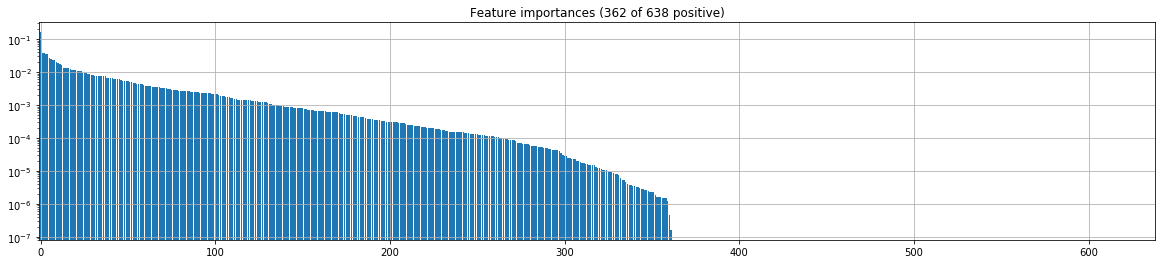

In [5]:
# Load data for the country
X, y = load_data('A')

# Get the feature importances
imp = show_importances(X, y)

In [6]:
# Put together the model (pipeline of a feature selector and classifier)
pipe = Pipeline([
    ('selector'  , SelectKBest(scores(imp))),
    ('estimator' , GradientBoostingClassifier())
])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-2)]: Done  75 out of  75 | elapsed:   57.2s finished


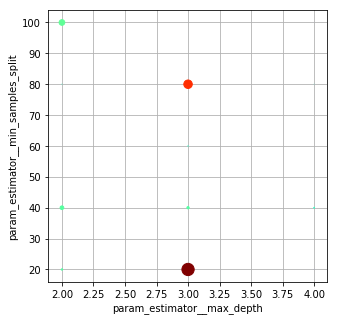

Best loss 0.273344958654
estimator__max_depth : 3
estimator__min_samples_split : 20


In [7]:
# Hyperparameter tuning by cross-validation
# (This cell would need to be run many times to fully tune the hyperparameters)
gs = GridSearchCV(
    estimator = pipe,
    param_grid = {
        'estimator__learning_rate'     : [.1], 
        'estimator__max_depth'         : [2,3,4], 
        'estimator__max_features'      : [18],
        'estimator__min_samples_leaf'  : [30], 
        'estimator__min_samples_split' : [20,40,60,80,100], 
        'estimator__n_estimators'      : [450],
        'estimator__subsample'         : [.8],
        'selector__k'                  : [350]        
    }, 
    scoring = 'neg_log_loss', 
    cv = StratifiedKFold(5, shuffle = True),
    n_jobs = -2, 
    verbose = 3
)
gs.fit(X[y >= 0], y[y >= 0])

allcols = cv_graph(gs)

print('Best loss', -gs.best_score_)
for c in allcols:
    c_ = c.replace('param_','')
    print(c_, ':', gs.best_params_[c_])

In [8]:
# Make the predictions for country A
clf = gs.best_estimator_
X['poor'] = clf.predict_proba(X)[:,1]
output = output.append(
    X[y < 0][['poor']].reset_index(), 
    ignore_index = True
)

In [9]:
# Update the estimated log loss score
score_n += sum(y < 0)
score_estimate += -gs.best_score_ * sum(y < 0)

## Country B

Calculating importances in batches: 100%|██████████████████████████████████████████████| 29/29 [28:13<00:00, 58.41s/it]


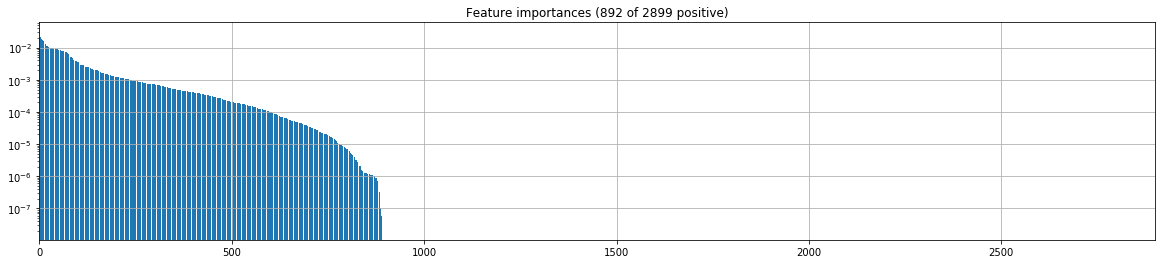

In [10]:
# Repeat all of the above for country B
X, y = load_data('B')
imp = show_importances(X, y)

In [11]:
pipe = Pipeline([
    ('selector'  , SelectKBest(scores(imp))),
    ('estimator' , GradientBoostingClassifier())
])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   28.2s finished


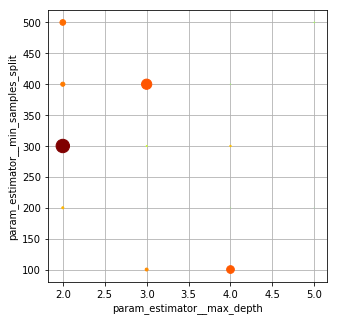

Best loss 0.190580079375
estimator__max_depth : 2
estimator__min_samples_split : 300


In [12]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = {
        'estimator__learning_rate'     : [.1], 
        'estimator__max_depth'         : [2,3,4,5], 
        'estimator__max_features'      : [20],
        'estimator__min_samples_leaf'  : [300], 
        'estimator__min_samples_split' : [100,200,300,400,500], 
        'estimator__n_estimators'      : [190], 
        'estimator__subsample'         : [.95],
        'selector__k'                  : [500],        
    }, 
    scoring = 'neg_log_loss', 
    cv = StratifiedKFold(5, shuffle = True),
    n_jobs = -2, 
    verbose = 3
)
gs.fit(X[y >= 0], y[y >= 0])

allcols = cv_graph(gs)

print('Best loss', -gs.best_score_)
for c in allcols:
    c_ = c.replace('param_','')
    print(c_, ':', gs.best_params_[c_])

In [13]:
clf = gs.best_estimator_
X['poor'] = clf.predict_proba(X)[:,1]
output = output.append(
    X[y < 0][['poor']].reset_index(), 
    ignore_index = True
)

In [14]:
score_n += sum(y < 0)
score_estimate += -gs.best_score_ * sum(y < 0)

## Country C

Calculating importances in batches: 100%|██████████████████████████████████████████████| 18/18 [19:02<00:00, 63.50s/it]


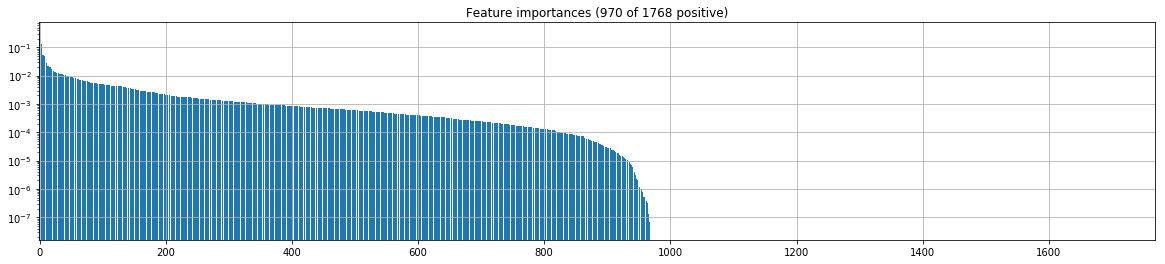

In [15]:
# Repeat all of the above for country C
X, y = load_data('C')
imp = show_importances(X, y)

In [16]:
pipe = Pipeline([
    ('selector'  , SelectKBest(scores(imp))),
    ('estimator' , GradientBoostingClassifier())
])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   39.8s finished


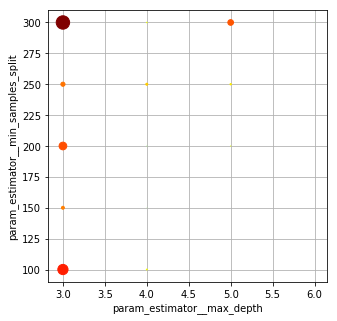

Best loss 0.0175638676689
estimator__max_depth : 3
estimator__min_samples_split : 300


In [17]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = {
        'estimator__learning_rate'     : [.1], 
        'estimator__max_depth'         : [3,4,5,6], 
        'estimator__max_features'      : [12],
        'estimator__min_samples_leaf'  : [50], 
        'estimator__min_samples_split' : [100,150,200,250,300],
        'estimator__n_estimators'      : [140], 
        'estimator__subsample'         : [.95],
        'selector__k'                  : [200],        
    }, 
    scoring = 'neg_log_loss', 
    cv = StratifiedKFold(5, shuffle = True),
    n_jobs = -2, 
    verbose = 3
)
gs.fit(X[y >= 0], y[y >= 0])

allcols = cv_graph(gs)

print('Best loss', -gs.best_score_)
for c in allcols:
    c_ = c.replace('param_','')
    print(c_, ':', gs.best_params_[c_])

In [18]:
clf = gs.best_estimator_
X['poor'] = clf.predict_proba(X)[:,1]
output = output.append(
    X[y < 0][['poor']].reset_index(), 
    ignore_index = True
)

In [19]:
score_n += sum(y < 0)
score_estimate += -gs.best_score_ * sum(y < 0)

## Exporting the predictions to be submitted

In [20]:
# The submission's estimated log loss score is a 
# weighed average of the cross-validation scores
print('Score estimate:', score_estimate / score_n)

Score estimate: 0.166016018059


In [21]:
# Find the largest submission file number already used
last = max(
    int(f.split('.')[0].strip('attempt')) for f in listdir() 
    if f.startswith('attempt')
)

# Output the current predictions with a new file name (e.g. `attempt008.csv`)
output.to_csv('attempt%s.csv' % (str(last + 1).zfill(3)), index = False)